# Text classification with CNN and RNN

We apply CNN and RNN to IMDB database, which includes 50,000 movie reviews, to do text classification. We construct different CNN and RNN structures, even we explore mix CNN-RNN model.Then all these results are compared to classical machine learning algorithms, naive bayes and SVM. we explore the influence of overfitting and regularization. 

## Import database


In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

In [3]:
word_index=imdb.get_word_index()

In [4]:
# # Convert .bin to .txt, read only 300000 top words

# from gensim.models.keyedvectors import KeyedVectors

# convert = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True,limit=300000)
# convert.save_word2vec_format('GoogleNews-vectors-negative300.txt', binary=False)

Every interger represents one words in the vocabulary.

**Transfer integer to words**

In [4]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
def save_history(history,model_name):
   #history: fit history
   # model_name:String, to generate a csv file to save the history
    import pandas as pd
    history_crnn=pd.DataFrame({'acc_train':history.history["acc"],'acc_val':history.history["val_acc"],
                                       'loss_train':history.history["loss"],'loss_val':history.history["val_loss"]
                         
                          })
    history_crnn.to_csv(model_name+'.csv')

## Data preprocessing

* pad the every sentence to uniform length
* use pre_trained glove data to represent the sentences


In [5]:
#model_list includes every models and how to generate embedding layer
import model_list

Using TensorFlow backend.


In [6]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [7]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [8]:
vocab_size=10000
embedding_size=300
max_length=256

In [9]:
#get embedding layer, default is use golve representation
embedding_layer=model_list.get_embedding_layer(word_index,USE_PRE=2,vocab_size=10000,embedding_size=300,max_length=256)

## CNN part

### Text CNN
[Reference Blog](http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/)

[Reference Paper](https://arxiv.org/abs/1408.5882)

In [10]:
text_cnn_model=model_list.text_cnn(embedding_layer)

In [11]:
print(text_cnn_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 256, 300)     3000000     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 256, 256)     230656      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 256, 256)     307456      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_3 (

In [12]:
history_text_cnn = text_cnn_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 18s 1ms/step - loss: 0.6730 - acc: 0.6154 - val_loss: 0.5070 - val_acc: 0.7654
Epoch 2/20
15000/15000 [==============================] - 15s 991us/step - loss: 0.3944 - acc: 0.8289 - val_loss: 0.3785 - val_acc: 0.8356
Epoch 3/20
15000/15000 [==============================] - 15s 995us/step - loss: 0.2971 - acc: 0.8821 - val_loss: 0.3380 - val_acc: 0.8554
Epoch 4/20
15000/15000 [==============================] - 15s 999us/step - loss: 0.2257 - acc: 0.9177 - val_loss: 0.3362 - val_acc: 0.8586
Epoch 5/20
15000/15000 [==============================] - 15s 997us/step - loss: 0.1486 - acc: 0.9615 - val_loss: 0.3352 - val_acc: 0.8626
Epoch 6/20
15000/15000 [==============================] - 15s 997us/step - loss: 0.0873 - acc: 0.9869 - val_loss: 0.3497 - val_acc: 0.8570
Epoch 7/20
15000/15000 [==============================] - 15s 999us/step - loss: 0.0541 - acc: 0.9965 - val_loss: 0.35

In [13]:
save_history(history_text_cnn,'history_text_cnn'+'_w2v')

In [14]:
loss_,accuracy_=text_cnn_model.evaluate(test_data,test_labels)
print('The loss on validation set is %f, accuracy is %f'%(loss_,accuracy_))

25000/25000 [==============================] - 10s 407us/step
The loss on validation set is 0.458208, accuracy is 0.858800


### Channel CNN

In [15]:
filter_sizes=[3,4,5]
feature_maps    = [100,100,100]
hidden_units=100
dropout_rate=.3

In [16]:
channel_cnn_model=model_list.Channel_cnn(embedding_layer,filter_sizes,feature_maps)

In [17]:
print(channel_cnn_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_input (InputLayer)         (None, 256)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 256, 300)     3000000     word_input[0][0]                 
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 300)     0           embedding_1[1][0]                
__________________________________________________________________________________________________
separable_conv1d_1 (SeparableCo (None, 256, 100)     123700      dropout_2[0][0]                  
__________________________________________________________________________________________________
separable_

In [18]:
history_channel_cnn = channel_cnn_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 27s 2ms/step - loss: 0.6489 - acc: 0.6389 - val_loss: 0.4932 - val_acc: 0.8204
Epoch 2/20
15000/15000 [==============================] - 26s 2ms/step - loss: 0.3956 - acc: 0.8280 - val_loss: 0.3506 - val_acc: 0.8484
Epoch 3/20
15000/15000 [==============================] - 26s 2ms/step - loss: 0.3300 - acc: 0.8590 - val_loss: 0.3173 - val_acc: 0.8653
Epoch 4/20
15000/15000 [==============================] - 26s 2ms/step - loss: 0.3003 - acc: 0.8732 - val_loss: 0.3008 - val_acc: 0.8729
Epoch 5/20
15000/15000 [==============================] - 26s 2ms/step - loss: 0.2667 - acc: 0.8921 - val_loss: 0.2961 - val_acc: 0.8748
Epoch 6/20
15000/15000 [==============================] - 26s 2ms/step - loss: 0.2450 - acc: 0.9010 - val_loss: 0.2840 - val_acc: 0.8846
Epoch 7/20
15000/15000 [==============================] - 26s 2ms/step - loss: 0.2160 - acc: 0.9161 - val_loss: 0.2809 - val_acc

In [19]:
save_history(history_channel_cnn,'history_channel_cnn'+'_w2v' )

In [20]:
loss_,accuracy_=channel_cnn_model.evaluate(test_data,test_labels)
print('The loss on validation set is %f, accuracy is %f'%(loss_,accuracy_))

25000/25000 [==============================] - 11s 459us/step
The loss on validation set is 0.369623, accuracy is 0.889840


## LSTM

[Understanding LSTM Network](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)


In [21]:
LSTM_model=model_list.single_LSTM(embedding_layer,cell_num=100,dropout_rate=0.2,recurrent_dropout_rate=0.1)

In [22]:
print(LSTM_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 300)          3000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 3,160,501
Trainable params: 160,501
Non-trainable params: 3,000,000
_________________________________________________________________
None


In [23]:
history_LSTM_model = LSTM_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 46s 3ms/step - loss: 0.6779 - acc: 0.5705 - val_loss: 0.6773 - val_acc: 0.5567
Epoch 2/20
15000/15000 [==============================] - 38s 3ms/step - loss: 0.6513 - acc: 0.6053 - val_loss: 0.6862 - val_acc: 0.5198
Epoch 3/20
15000/15000 [==============================] - 38s 3ms/step - loss: 0.6866 - acc: 0.5237 - val_loss: 0.6853 - val_acc: 0.5213
Epoch 4/20
15000/15000 [==============================] - 40s 3ms/step - loss: 0.6799 - acc: 0.5444 - val_loss: 0.6780 - val_acc: 0.5466
Epoch 5/20
15000/15000 [==============================] - 38s 3ms/step - loss: 0.6759 - acc: 0.5518 - val_loss: 0.6620 - val_acc: 0.6188
Epoch 6/20
15000/15000 [==============================] - 39s 3ms/step - loss: 0.6821 - acc: 0.5405 - val_loss: 0.6810 - val_acc: 0.5404
Epoch 7/20
15000/15000 [==============================] - 39s 3ms/step - loss: 0.6735 - acc: 0.5523 - val_loss: 0.6716 - val_acc

In [24]:
save_history(history_LSTM_model,'history_LSTM_model'+'_w2v' )

In [25]:
loss_,accuracy_=LSTM_model.evaluate(test_data,test_labels)
print('The loss on validation set is %f, accuracy is %f'%(loss_,accuracy_))

25000/25000 [==============================] - 148s 6ms/step
The loss on validation set is 0.314164, accuracy is 0.868560


## Bi-GRU (take a long time)
[Recurrent Neural Network for Text Classification with Multi-Task Learning](https://www.ijcai.org/Proceedings/16/Papers/408.pdf)

In [24]:
# Bi_GRU_model=model_list.Bi_GRU(embedding_layer,cell_num=128,dropout_rate=0.2,recurrent_dropout_rate=0.1)

In [ ]:
# print(Bi_GRU_model.summary())

In [ ]:
# history_Bi_GRU_model = Bi_GRU_model.fit(partial_x_train,
#                     partial_y_train,
#                     epochs=6,
#                     batch_size=256,
#                     validation_data=(x_val, y_val),
#                     verbose=1)

In [ ]:
# save_history(history_Bi_GRU_model,'history_Bi_GRU_model' )

## C_GRU_Series

[A C-LSTM Neural Network for Text Classification](https://arxiv.org/abs/1511.08630)

In [26]:
C_GRU_series_model=model_list.C_RNN_series(embedding_layer)

In [27]:
print(C_GRU_series_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 300)          3000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 256, 128)          115328    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 128, 128)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128, 128)          98688     
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               98688     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 3,312,833
Trainable params: 312,833
Non-trainable params: 3,000,000
____________________________________________________________

In [28]:
history_C_GRU_series_model= C_GRU_series_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 36s 2ms/step - loss: 0.6800 - acc: 0.5364 - val_loss: 0.6547 - val_acc: 0.5953
Epoch 2/20
15000/15000 [==============================] - 36s 2ms/step - loss: 0.5722 - acc: 0.7415 - val_loss: 0.5732 - val_acc: 0.7301
Epoch 3/20
15000/15000 [==============================] - 36s 2ms/step - loss: 0.5832 - acc: 0.7180 - val_loss: 0.5477 - val_acc: 0.7612
Epoch 4/20
15000/15000 [==============================] - 36s 2ms/step - loss: 0.6864 - acc: 0.5635 - val_loss: 0.6639 - val_acc: 0.5675
Epoch 5/20
15000/15000 [==============================] - 37s 2ms/step - loss: 0.6496 - acc: 0.5749 - val_loss: 0.6261 - val_acc: 0.6253
Epoch 6/20
15000/15000 [==============================] - 37s 2ms/step - loss: 0.5724 - acc: 0.7090 - val_loss: 0.5486 - val_acc: 0.7777
Epoch 7/20
15000/15000 [==============================] - 36s 2ms/step - loss: 0.4388 - acc: 0.8188 - val_loss: 0.4235 - val_acc

In [29]:
save_history(history_C_GRU_series_model,'history_C_GRU_series_model'+'_w2v' )

In [30]:
loss_,accuracy_=C_GRU_series_model.evaluate(test_data,test_labels)
print('The loss on validation set is %f, accuracy is %f'%(loss_,accuracy_))

25000/25000 [==============================] - 132s 5ms/step
The loss on validation set is 0.274953, accuracy is 0.881920


## C_GRU_Parallel 

No reference paper

In [31]:
C_RNN_Parallel_model=model_list.C_RNN_Parallel(embedding_layer)

In [32]:
print(C_RNN_Parallel_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 256, 300)     3000000     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 256, 256)     230656      embedding_1[4][0]                
__________________________________________________________________________________________________
max_pooling1d_5 (MaxPooling1D)  (None, 64, 256)      0           conv1d_5[0][0]                   
__________________________________________________________________________________________________
flatten_2 

In [33]:
history_C_RNN_Parallel_model= C_RNN_Parallel_model.fit(partial_x_train,#very slow
                    partial_y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 76s 5ms/step - loss: 0.8174 - acc: 0.5781 - val_loss: 0.6376 - val_acc: 0.6017
Epoch 2/20
15000/15000 [==============================] - 75s 5ms/step - loss: 0.5245 - acc: 0.7473 - val_loss: 0.4110 - val_acc: 0.8214
Epoch 3/20
15000/15000 [==============================] - 76s 5ms/step - loss: 0.3541 - acc: 0.8478 - val_loss: 0.3411 - val_acc: 0.8567
Epoch 4/20
15000/15000 [==============================] - 76s 5ms/step - loss: 0.2958 - acc: 0.8771 - val_loss: 0.3212 - val_acc: 0.8673
Epoch 5/20
15000/15000 [==============================] - 76s 5ms/step - loss: 0.2342 - acc: 0.9089 - val_loss: 0.3252 - val_acc: 0.8661
Epoch 6/20
15000/15000 [==============================] - 77s 5ms/step - loss: 0.1464 - acc: 0.9504 - val_loss: 0.3502 - val_acc: 0.8624
Epoch 7/20
15000/15000 [==============================] - 78s 5ms/step - loss: 0.0597 - acc: 0.9883 - val_loss: 0.4469 - val_acc

In [34]:
save_history(history_C_RNN_Parallel_model,'history_C_RNN_Parallel_model'+'_w2v' )

In [35]:
loss_,accuracy_=C_RNN_Parallel_model.evaluate(test_data,test_labels)
print('The loss on validation set is %f, accuracy is %f'%(loss_,accuracy_))

25000/25000 [==============================] - 186s 7ms/step
The loss on validation set is 0.643434, accuracy is 0.856040


## Visulization

In [36]:
#matplotlib inline
import matplotlib.pyplot as plt

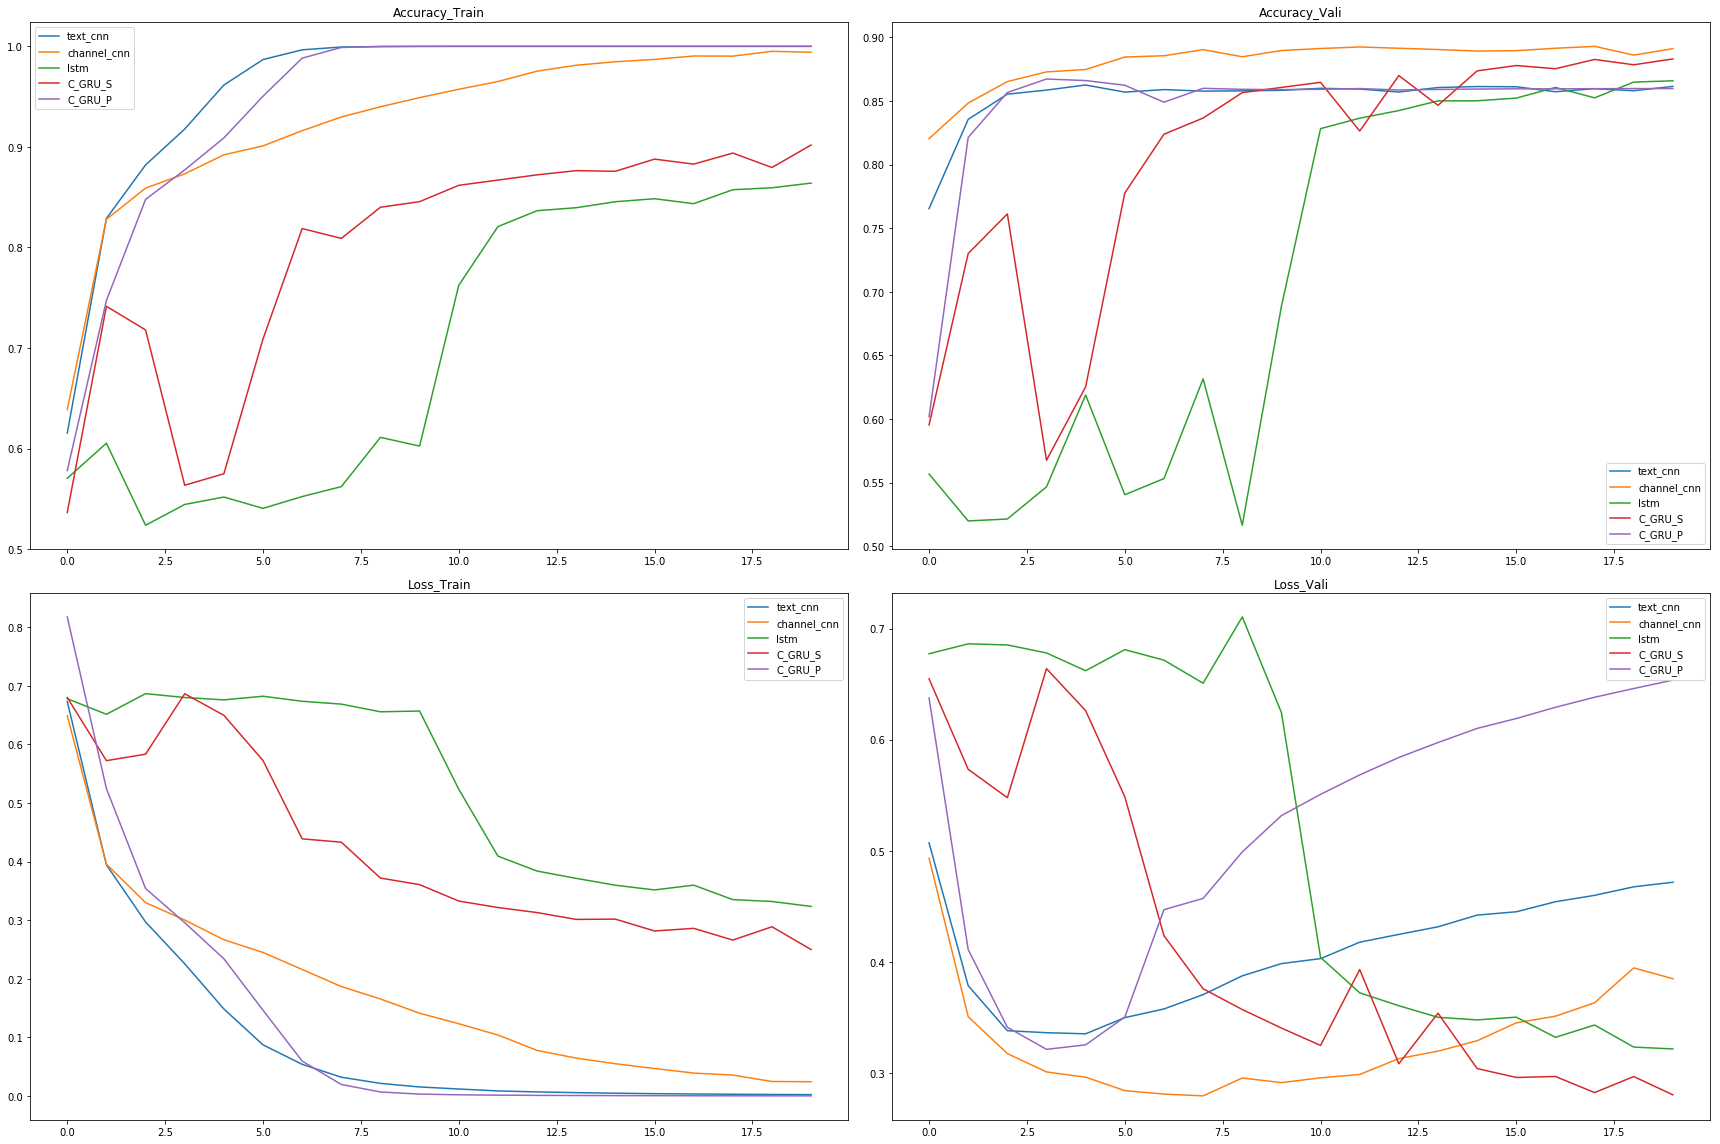

In [37]:
plt.figure(figsize=[24,16]) 
plt.subplot(221)
plt.title('Accuracy_Train')
plt.plot(history_text_cnn.history['acc'],label='text_cnn')
plt.plot(history_channel_cnn.history['acc'],label='channel_cnn')
# plt.plot(history_Bi_GRU_model.history['acc'],label='Bi_GRU')
plt.plot(history_LSTM_model.history['acc'],label='lstm')
plt.plot(history_C_GRU_series_model.history['acc'],label='C_GRU_S')
plt.plot(history_C_RNN_Parallel_model.history['acc'],label='C_GRU_P')
plt.legend(loc='best')

plt.subplot(222)
plt.title('Accuracy_Vali')
plt.plot(history_text_cnn.history['val_acc'],label='text_cnn')
plt.plot(history_channel_cnn.history['val_acc'],label='channel_cnn')
# plt.plot(history_Bi_GRU_model.history['val_acc'],label='Bi_GRU')
plt.plot(history_LSTM_model.history['val_acc'],label='lstm')
plt.plot(history_C_GRU_series_model.history['val_acc'],label='C_GRU_S')
plt.plot(history_C_RNN_Parallel_model.history['val_acc'],label='C_GRU_P')
plt.legend(loc='best')

plt.subplot(223)
plt.title('Loss_Train')
plt.plot(history_text_cnn.history['loss'],label='text_cnn')
plt.plot(history_channel_cnn.history['loss'],label='channel_cnn')
# plt.plot(history_Bi_GRU_model.history['loss'],label='Bi_GRU')
plt.plot(history_LSTM_model.history['loss'],label='lstm')
plt.plot(history_C_GRU_series_model.history['loss'],label='C_GRU_S')
plt.plot(history_C_RNN_Parallel_model.history['loss'],label='C_GRU_P')
plt.legend(loc='best')

plt.subplot(224)
plt.title('Loss_Vali')
plt.plot(history_text_cnn.history['val_loss'],label='text_cnn')
plt.plot(history_channel_cnn.history['val_loss'],label='channel_cnn')
# plt.plot(history_Bi_GRU_model.history['val_loss'],label='Bi_GRU')
plt.plot(history_LSTM_model.history['val_loss'],label='lstm')
plt.plot(history_C_GRU_series_model.history['val_loss'],label='C_GRU_S')
plt.plot(history_C_RNN_Parallel_model.history['val_loss'],label='C_GRU_P')
plt.legend(loc='best')
plt.savefig('all_models'+'_w2v')
plt.tight_layout()
plt.show()


## regularization

### regularizer.l2

In [58]:
C_RNN_Parallel_model_reg=model_list.C_RNN_Parallel2(embedding_layer,reg_coef=0.01)

In [59]:
print(C_RNN_Parallel_model_reg.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 256, 300)     3000000     input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 256, 256)     230656      embedding_1[8][0]                
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 256, 256)     0           conv1d_9[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [60]:
history_C_RNN_Parallel_model_reg= C_RNN_Parallel_model_reg.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 79s 5ms/step - loss: 2.2254 - acc: 0.5686 - val_loss: 1.0410 - val_acc: 0.6319
Epoch 2/20
15000/15000 [==============================] - 81s 5ms/step - loss: 0.6799 - acc: 0.7516 - val_loss: 0.4654 - val_acc: 0.8310
Epoch 3/20
15000/15000 [==============================] - 87s 6ms/step - loss: 0.4379 - acc: 0.8301 - val_loss: 0.3871 - val_acc: 0.8562
Epoch 4/20
15000/15000 [==============================] - 80s 5ms/step - loss: 0.3574 - acc: 0.8635 - val_loss: 0.3617 - val_acc: 0.8597
Epoch 5/20
15000/15000 [==============================] - 79s 5ms/step - loss: 0.3372 - acc: 0.8717 - val_loss: 0.3511 - val_acc: 0.8654
Epoch 6/20
15000/15000 [==============================] - 80s 5ms/step - loss: 0.3181 - acc: 0.8804 - val_loss: 0.3611 - val_acc: 0.8633
Epoch 7/20
15000/15000 [==============================] - 81s 5ms/step - loss: 0.2911 - acc: 0.8971 - val_loss: 0.3528 - val_acc

In [61]:
save_history(history_C_RNN_Parallel_model_reg,'history_C_RNN_Parallel_model_reg'+'_w2v' )

In [62]:
loss_,accuracy_=C_RNN_Parallel_model_reg.evaluate(test_data,test_labels)
print('The loss on validation set is %f, accuracy is %f'%(loss_,accuracy_))

25000/25000 [==============================] - 207s 8ms/step
The loss on validation set is 0.583139, accuracy is 0.854240


### dropout

In [63]:
C_RNN_Parallel_model_dropout=model_list.C_RNN_Parallel2(embedding_layer,dropout_rate_conv=0.4)

In [64]:
print(C_RNN_Parallel_model_dropout.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 256, 300)     3000000     input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 256, 256)     230656      embedding_1[9][0]                
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 256, 256)     0           conv1d_10[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [65]:
history_C_RNN_Parallel_model_dropout= C_RNN_Parallel_model_dropout.fit(partial_x_train,#very slow
                    partial_y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 99s 7ms/step - loss: 0.9497 - acc: 0.5667 - val_loss: 0.6179 - val_acc: 0.6800
Epoch 2/20
15000/15000 [==============================] - 98s 7ms/step - loss: 0.5852 - acc: 0.6991 - val_loss: 0.5233 - val_acc: 0.7536
Epoch 3/20
15000/15000 [==============================] - 99s 7ms/step - loss: 0.3943 - acc: 0.8233 - val_loss: 0.3483 - val_acc: 0.8523
Epoch 4/20
15000/15000 [==============================] - 104s 7ms/step - loss: 0.3313 - acc: 0.8575 - val_loss: 0.3295 - val_acc: 0.8618
Epoch 5/20
15000/15000 [==============================] - 90s 6ms/step - loss: 0.2906 - acc: 0.8815 - val_loss: 0.3169 - val_acc: 0.8674
Epoch 6/20
15000/15000 [==============================] - 91s 6ms/step - loss: 0.2470 - acc: 0.9014 - val_loss: 0.3135 - val_acc: 0.8667
Epoch 7/20
15000/15000 [==============================] - 93s 6ms/step - loss: 0.1915 - acc: 0.9258 - val_loss: 0.3338 - val_ac

In [78]:
save_history(history_C_RNN_Parallel_model_dropout,'history_C_RNN_Parallel_model_dropout'+'_w2v' )

In [67]:
loss_,accuracy_=C_RNN_Parallel_model_dropout.evaluate(test_data,test_labels)
print('The loss on validation set is %f, accuracy is %f'%(loss_,accuracy_))

25000/25000 [==============================] - 185s 7ms/step
The loss on validation set is 0.616552, accuracy is 0.861920


## Visualization

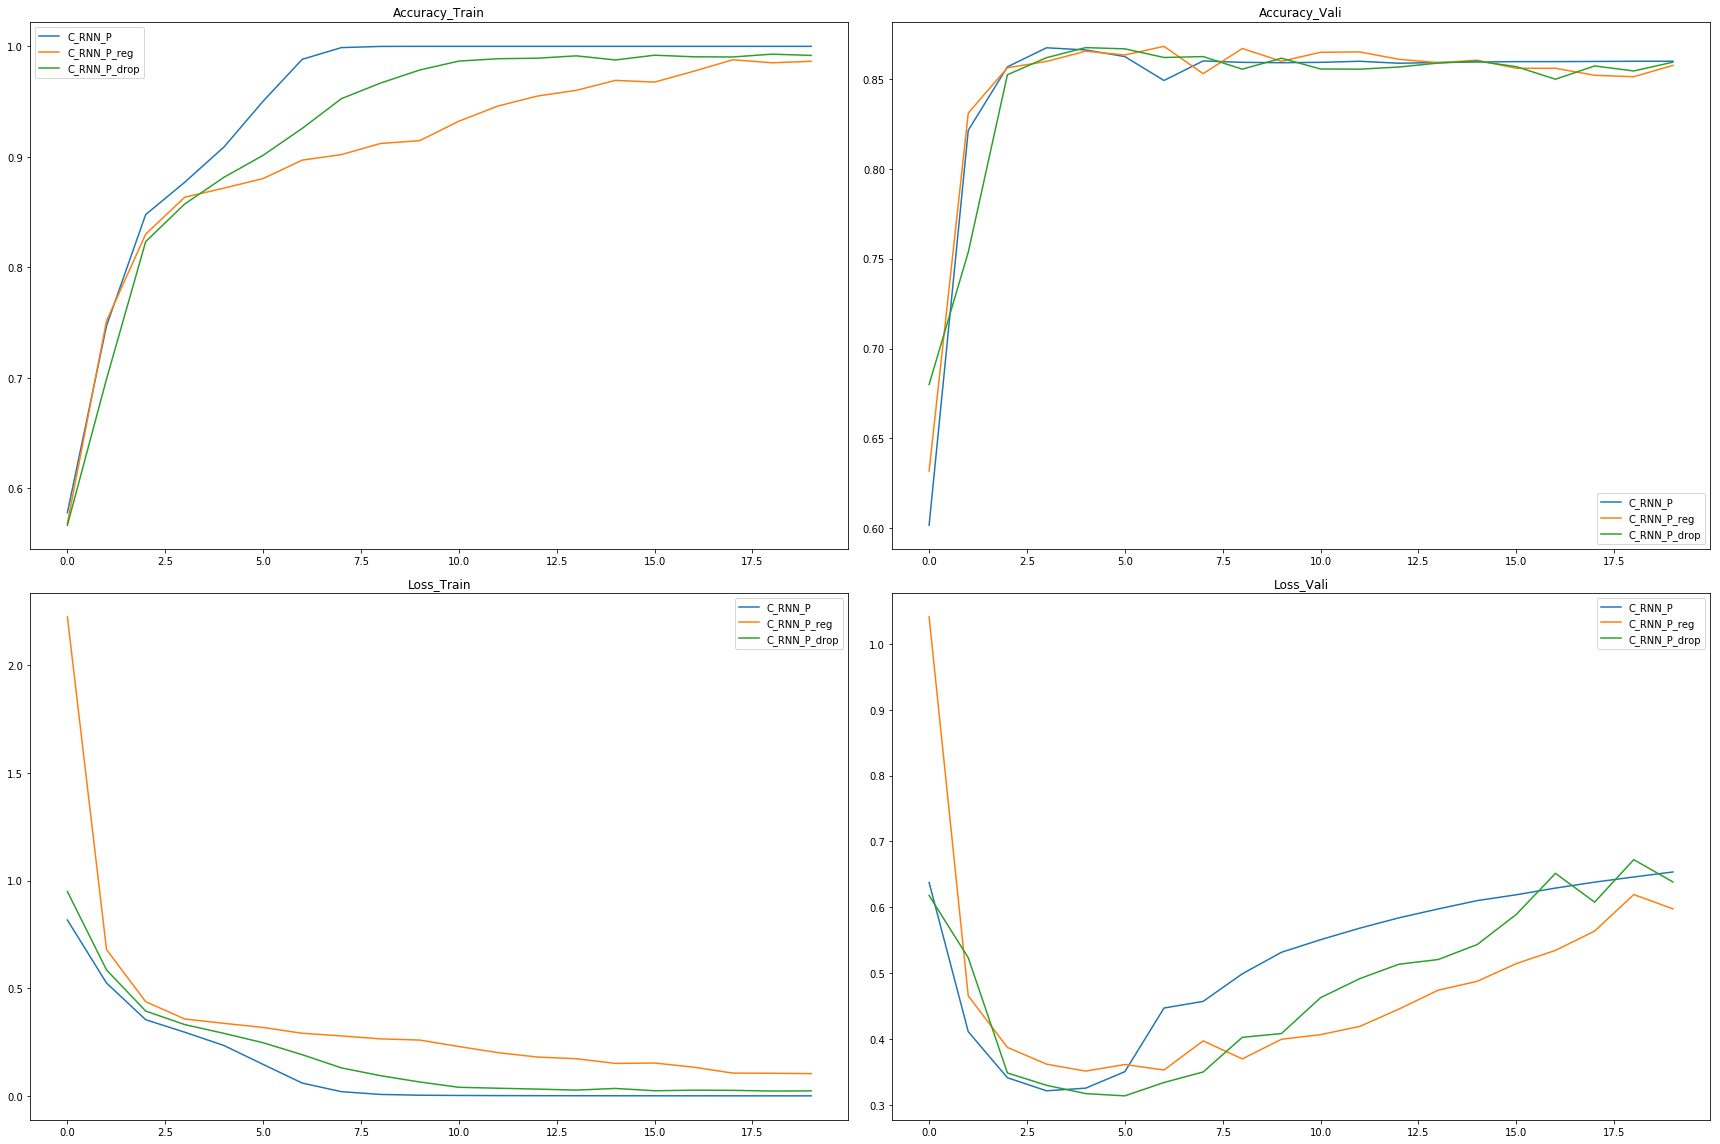

In [73]:
plt.figure(figsize=[24,16])

plt.subplot(221)
plt.title('Accuracy_Train')
plt.plot(history_C_RNN_Parallel_model.history['acc'],label='C_RNN_P')
plt.plot(history_C_RNN_Parallel_model_reg.history['acc'],label='C_RNN_P_reg')
plt.plot(history_C_RNN_Parallel_model_dropout.history['acc'],label='C_RNN_P_drop')
plt.legend(loc='best')

plt.subplot(222)
plt.title('Accuracy_Vali')
plt.plot(history_C_RNN_Parallel_model.history['val_acc'],label='C_RNN_P')
plt.plot(history_C_RNN_Parallel_model_reg.history['val_acc'],label='C_RNN_P_reg')
plt.plot(history_C_RNN_Parallel_model_dropout.history['val_acc'],label='C_RNN_P_drop')
plt.legend(loc='best')

plt.subplot(223)
plt.title('Loss_Train')
plt.plot(history_C_RNN_Parallel_model.history['loss'],label='C_RNN_P')
plt.plot(history_C_RNN_Parallel_model_reg.history['loss'],label='C_RNN_P_reg')
plt.plot(history_C_RNN_Parallel_model_dropout.history['loss'],label='C_RNN_P_drop')
plt.legend(loc='best')

plt.subplot(224)
plt.title('Loss_Vali')
plt.plot(history_C_RNN_Parallel_model.history['val_loss'],label='C_RNN_P')
plt.plot(history_C_RNN_Parallel_model_reg.history['val_loss'],label='C_RNN_P_reg')
plt.plot(history_C_RNN_Parallel_model_dropout.history['val_loss'],label='C_RNN_P_drop')
plt.legend(loc='best')
plt.savefig('reg_and_drop'+'_w2v'+'.png')
plt.tight_layout()
plt.show()
